# 토픽 트렌드로 시간에 따른 주제의 변환 알아보기

## [청와대 국민청원 사이트의 만료 청원 데이터](https://github.com/akngs/petitions) 이용

In [1]:
import pandas as pd

df = pd.read_csv('../data/petition_sampled.csv')
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
t = Okt()

def tokenizer(doc):
    return [token for token in t.nouns(doc) if len(token) > 1]   # 명사 추출

cv = CountVectorizer(tokenizer=tokenizer, max_df=0.5, min_df = 5, max_features = 1000) 

pet_cv = cv.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [3]:
from sklearn.decomposition import LatentDirichletAllocation

# LDA - 15개 토픽
lda = LatentDirichletAllocation(n_components = 15, n_jobs= -1, random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# 토픽별로 빈도가 높은 단어 15개 출력
print_top_words(lda, cv.get_feature_names_out(), 15)

CPU times: total: 2.98 s
Wall time: 57.7 s
Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 자신, 피해, 환자, 가족, 범죄, 정말, 대한, 폭행
Topic #1: 북한, 한국, 우리, 대통령, 정부, 미국, 대한민국, 국민, 일본, 국가, 문제, 생각, 우리나라, 중국, 문재인
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 저희, 출산, 아빠
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 사찰, 게임, 생각, 이용, 소음, 사람, 나이, 사회, 노인
Topic #4: 국민, 대통령, 정부, 나라, 정책, 주택, 부동산, 서민, 사람, 지금, 아파트, 문재인, 세금, 대한민국, 투기
Topic #5: 일자리, 기업, 정부, 근무, 생각, 근로자, 지원, 임금, 최저임금, 정책, 시간, 직원, 사람, 고용, 대기업
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 생각, 반대, 청와대, 세금, 제도, 동의, 정치, 투표, 대통령, 국가
Topic #7: 대한, 관리, 내용, 조사, 판결, 관련, 공사, 업무, 판사, 사실, 기관, 해당, 확인, 결과, 위원회
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 의료, 보험료, 기초, 건강, 공단, 수급
Topic #10: 여성, 공무원, 사회, 남성, 생각, 의무, 남자, 대한민국, 여자, 행정, 군대, 사람, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 위해, 대한민국, 조직, 불법, 만행, 사건, 수사, 범죄자, 부정부패, 검찰, 빨갱이, 살인마
Topic #12: 차량, 사고, 처벌, 사건, 신고, 주차, 증거, 기사, 경우, 택시, 안전, 이명박, 발생, 운전, 도로
Topic #13:

In [4]:
# 청원 작성 날짜(start) 가져오기
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
trend = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend = pd.concat([trend, df.start.map(lambda x: x[:7])], axis=1)   # start 컬럼과 토픽 분포 합치기, start는 월까지만 가져옴
trend.iloc[:5, -5:]    # 뒷 열 5개 출력

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.460206,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.000447,0.000447,0.000447,2017-08


In [5]:
# 월별 토픽 평균
trend = trend.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.031905,0.010507,0.036244,0.025885,0.106103
2017-09,0.042780,0.024993,0.037086,0.021294,0.044257
2017-10,0.089529,0.053818,0.050834,0.033566,0.097228
2017-11,0.046314,0.046327,0.216338,0.041019,0.049564
2017-12,0.056824,0.026315,0.066910,0.050224,0.078167


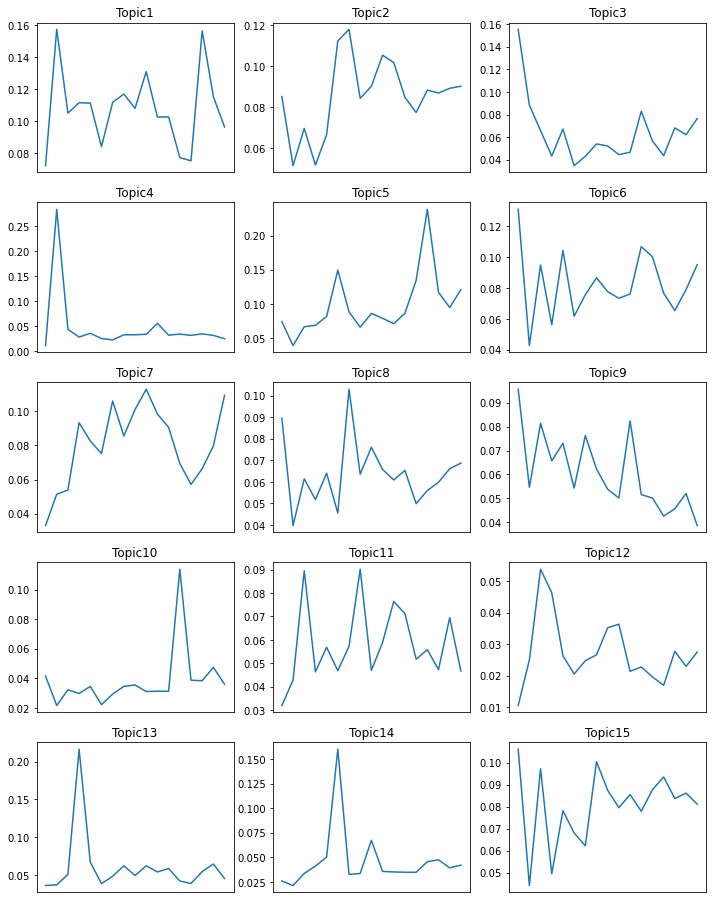

In [6]:
# 시각화
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 5X3 그래프
fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()
# Cold topic: 초기에 비중이 높았다가 점점 줄어드는 경향을 보임 ex) Topic3, Topic4, Topic9, Topic13
# Hot topic: 뒤로 가면서 비중이 높아지는 경향 ex) Topic5